In [1]:
# Import necessary libraries
import torch
import numpy as np
import xgboost as xgb
from PIL import Image
import torchvision.transforms as transforms
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Paths and Parameters
checkpoint_path = r'C:\Users\Josh\Desktop\CUDA\alexnetmodel\53 with CLAHE.pth'  # Path to AlexNet model weights
xgb_model_path = r'C:\Users\Josh\Desktop\CUDA\withpca\final_xgboost_model.json'
input_folder = r'C:\Users\Josh\Desktop\CUDA\skindiseases\test'  
SEED = 42

# Set the seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)


In [3]:
import cv2
from PIL import Image

class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        # Convert PIL Image to NumPy array
        img_np = np.array(img)
        
        # Apply CLAHE on each channel independently if it's a color image
        if len(img_np.shape) == 3:
            channels = cv2.split(img_np)
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            channels = [clahe.apply(channel) for channel in channels]
            img_np = cv2.merge(channels)
        else:
            # Apply CLAHE on grayscale images
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            img_np = clahe.apply(img_np)

        # Convert back to PIL Image
        img_clahe = Image.fromarray(img_np)
        return img_clahe


In [4]:
# Image and model parameters
INPUT_SIZE = (256, 256)
MEAN = (0.6181, 0.4643, 0.4194)
STD = (0.1927, 0.1677, 0.1617)

# Define the image transformations
transform_test = transforms.Compose([
    CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Resize(INPUT_SIZE),
    transforms.CenterCrop((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Define class names
class_names = ['Acne', 'Eczema', 'Normal', 'Perioral Dermatitis', 'Psoriasis', 'Rosacea', 'Seborrheic Dermatitis', 'Tinea Faciei']

In [5]:
import torch.nn as nn
from torchvision import models

# Load the pre-trained AlexNet model
model = models.alexnet(pretrained=False)  # Set pretrained=False to load custom weights
model.classifier = nn.Sequential(*list(model.classifier.children())[:3])  # Modify classifier to stop at fc6

# Load the custom weights with correction for key mismatches
state_dict = torch.load(checkpoint_path, weights_only=True)
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("model.", "") if k.startswith("model.") else k
    if new_key in model.state_dict().keys():
        new_state_dict[new_key] = v
        
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(new_state_dict, strict=False)
model.eval()


c:\Users\Josh\Desktop\CUDA\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Josh\Desktop\CUDA\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
# Load the XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.load_model(xgb_model_path)
print(f"Loaded XGBoost model from {xgb_model_path}")

Loaded XGBoost model from C:\Users\Josh\Desktop\CUDA\withpca\final_xgboost_model.json


In [7]:
# Function to process images and evaluate model performance
def evaluate_model_on_images(folder_path, class_names):
    true_labels = []
    predicted_labels = []
    
    # Traverse each subfolder (assuming each subfolder is a class category)
    for subfolder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder_name)
        
        if os.path.isdir(subfolder_path):
            true_label_index = class_names.index(subfolder_name)  # Get the true label index for the class
            
            print(f"Processing images in subfolder: {subfolder_name}")
            for image_name in tqdm(os.listdir(subfolder_path), desc=f"Predicting {subfolder_name}"):
                image_path = os.path.join(subfolder_path, image_name)
                
                if image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    try:
                        # Load and preprocess the image
                        image = Image.open(image_path).convert("RGB")
                        image = transform_test(image)
                        image = image.unsqueeze(0).to(device)
                        
                        # Extract features using the AlexNet model
                        with torch.no_grad():
                            features = model(image).cpu().numpy()
                        
                        # Predict with the XGBoost model
                        prediction_index = xgb_model.predict(features)[0]
                        
                        # Append to true and predicted labels
                        true_labels.append(true_label_index)
                        predicted_labels.append(prediction_index)
                        
                    except Exception as e:
                        print(f"Error processing {image_name}: {e}")
        # Calculate and print accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=class_names))
    
    # Display the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix on Alexnet Without XGBOOST')
    plt.show()

Processing images in subfolder: Acne


Predicting Acne: 100%|██████████| 50/50 [00:00<00:00, 57.92it/s]


Processing images in subfolder: Eczema


Predicting Eczema: 100%|██████████| 50/50 [00:01<00:00, 34.53it/s]


Processing images in subfolder: Normal


Predicting Normal: 100%|██████████| 50/50 [00:01<00:00, 41.07it/s]


Processing images in subfolder: Perioral Dermatitis


Predicting Perioral Dermatitis: 100%|██████████| 50/50 [00:00<00:00, 65.92it/s]


Processing images in subfolder: Psoriasis


Predicting Psoriasis: 100%|██████████| 50/50 [00:01<00:00, 29.66it/s]


Processing images in subfolder: Rosacea


Predicting Rosacea: 100%|██████████| 50/50 [00:01<00:00, 41.25it/s]


Processing images in subfolder: Seborrheic Dermatitis


Predicting Seborrheic Dermatitis: 100%|██████████| 50/50 [00:00<00:00, 59.85it/s]


Processing images in subfolder: Tinea Faciei


Predicting Tinea Faciei: 100%|██████████| 50/50 [00:00<00:00, 75.35it/s]



Test Accuracy: 52.00%

Classification Report:
                       precision    recall  f1-score   support

                 Acne       0.70      0.64      0.67        50
               Eczema       0.32      0.36      0.34        50
               Normal       0.81      0.58      0.67        50
  Perioral Dermatitis       0.48      0.60      0.54        50
            Psoriasis       0.46      0.42      0.44        50
              Rosacea       0.54      0.64      0.59        50
Seborrheic Dermatitis       0.50      0.48      0.49        50
         Tinea Faciei       0.47      0.44      0.45        50

             accuracy                           0.52       400
            macro avg       0.53      0.52      0.52       400
         weighted avg       0.53      0.52      0.52       400



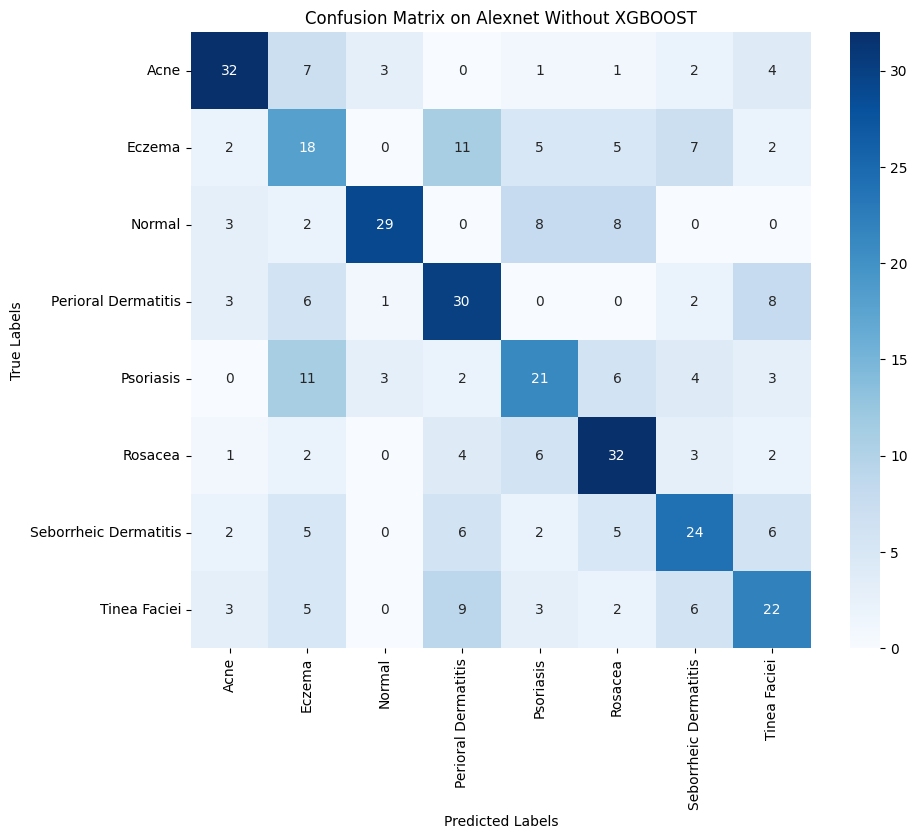

In [8]:
# Run the evaluation
evaluate_model_on_images(input_folder, class_names)
